In [113]:
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
import pandas as pd
from meld_classifier.define_features import Feature

In [2]:
cohort = MeldCohort(hdf5_file_root="{site_code}_{group}_featurematrix_combat.hdf5", dataset="MELD_dataset_V6.csv",
                   data_dir="/home/co-spit1/meld_data")

In [63]:
# get all patients and controls
patient_ids = cohort.get_subject_ids(group='patient')
control_ids = cohort.get_subject_ids(group='control')
print(len(patient_ids), 'patients', len(control_ids), 'controls')

# get all features
for f in cohort.full_feature_list:
    print(f)

525 patients 372 controls
.combat.on_lh.curv.mgh
.combat.on_lh.gm_FLAIR_0.25.sm10.mgh
.combat.on_lh.gm_FLAIR_0.5.sm10.mgh
.combat.on_lh.gm_FLAIR_0.75.sm10.mgh
.combat.on_lh.gm_FLAIR_0.sm10.mgh
.combat.on_lh.pial.K_filtered.sm20.mgh
.combat.on_lh.sulc.mgh
.combat.on_lh.thickness.sm10.mgh
.combat.on_lh.w-g.pct.sm10.mgh
.combat.on_lh.wm_FLAIR_0.5.sm10.mgh
.combat.on_lh.wm_FLAIR_1.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.curv.mgh
.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.25.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh
.inter_z.asym.intra_z.combat.on_lh.sulc.mgh
.inter_z.asym.intra_z.combat.on_lh.thickness.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.w-g.pct.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_0.5.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_1.sm10.mgh
.inter_z.intra_z.

In [142]:
def get_control_features(subject_ids, feature, cohort):
    """
    preload features from controls for a list of controls
    """
    control_features = {'lh':[], 'rh': []}
    for hemi in ['lh', 'rh']:
        for sid in subject_ids:
            subj = MeldSubject(sid, cohort)
            features = subj.load_feature_values(feature, hemi=hemi)
            control_features[hemi].append(features)
        control_features[hemi] = np.stack(control_features[hemi], axis=1)
    return control_features

def get_tstat_for_subject(subject_id, feature, control_features, cohort):
    """
    calc tstst for one subject id and preloaded control features
    """
    subj = MeldSubject(subject_id, cohort)
    hemi = subj.get_lesion_hemisphere()
    features, lesion = subj.load_feature_lesion_data([feature], hemi=hemi)
    
    patient_features = features[lesion].flatten()
    cur_control_features = control_features[hemi][lesion].flatten()
    
    # calculate tstat
    tstat, p = ttest_ind(patient_features, cur_control_features, equal_var=False)
    return tstat

def get_tstat(patient_ids, control_ids, feature, cohort):
    """
    return list of tstats for each patient comparing to controls
    """
    control_features = get_control_features(control_ids, feature, cohort)
    stats = []
    for pid in patient_ids:
        stats.append(get_tstat_for_subject(pid, feature, control_features, cohort))
    return stats

def get_tstat_for_features(patient_ids, control_ids, features, cohort):
    """
    calculate tstats for all patients + matching controls for all features in features dict
    """
    stats = []
    for ftype, fdict in features.items():
        cur_stats = {}
        for fname, feature in fdict.items():
            cur_stats[fname] = get_tstat(patient_ids, control_ids, feature, cohort)
        cur_stats = pd.DataFrame(cur_stats)
        cur_stats['processing'] = ftype
        stats.append(cur_stats)
    return pd.concat(stats)

In [91]:
cohort.full_feature_list

['.combat.on_lh.curv.mgh',
 '.combat.on_lh.gm_FLAIR_0.25.sm10.mgh',
 '.combat.on_lh.gm_FLAIR_0.5.sm10.mgh',
 '.combat.on_lh.gm_FLAIR_0.75.sm10.mgh',
 '.combat.on_lh.gm_FLAIR_0.sm10.mgh',
 '.combat.on_lh.pial.K_filtered.sm20.mgh',
 '.combat.on_lh.sulc.mgh',
 '.combat.on_lh.thickness.sm10.mgh',
 '.combat.on_lh.w-g.pct.sm10.mgh',
 '.combat.on_lh.wm_FLAIR_0.5.sm10.mgh',
 '.combat.on_lh.wm_FLAIR_1.sm10.mgh',
 '.inter_z.asym.intra_z.combat.on_lh.curv.mgh',
 '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.25.sm10.mgh',
 '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh',
 '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh',
 '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.sm10.mgh',
 '.inter_z.asym.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh',
 '.inter_z.asym.intra_z.combat.on_lh.sulc.mgh',
 '.inter_z.asym.intra_z.combat.on_lh.thickness.sm10.mgh',
 '.inter_z.asym.intra_z.combat.on_lh.w-g.pct.sm10.mgh',
 '.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_0.5.sm10.mgh',
 '.inter_z.asy

## compare combat vs asym for noFLAIR features

In [140]:
# set up data for comparing combat vs asym features (no FLAIR features)
base_features = [
    '.on_lh.curv.mgh', 
    '.on_lh.pial.K_filtered.mgh',
    '.on_lh.sulc.mgh',
    '.on_lh.thickness.mgh',
    '.on_lh.w-g.pct.mgh',
    ]
smooth = [None, 20, None, 10, 10]

# build feature names for comparing combat vs asym
features = {
    'combat': {f:Feature(f, sm).get_combat_feature() for f,sm in zip(base_features, smooth)},
    'asym': {f:Feature(f, sm).get_asym_feature() for f,sm in zip(base_features, smooth)}
}
print(features)

# choose random controls to compare against
cur_control_ids = np.random.choice(control_ids, size=50, replace=False)

# Q: for FLAIR, choose only patients + controls that have flair
# Q: match scanner strength for patients + controls?

{'combat': {'.on_lh.curv.mgh': '.combat.on_lh.curv.mgh', '.on_lh.pial.K_filtered.mgh': '.combat.on_lh.pial.K_filtered.sm20.mgh', '.on_lh.sulc.mgh': '.combat.on_lh.sulc.mgh', '.on_lh.thickness.mgh': '.combat.on_lh.thickness.sm10.mgh', '.on_lh.w-g.pct.mgh': '.combat.on_lh.w-g.pct.sm10.mgh'}, 'asym': {'.on_lh.curv.mgh': '.inter_z.asym.intra_z.combat.on_lh.curv.mgh', '.on_lh.pial.K_filtered.mgh': '.inter_z.asym.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh', '.on_lh.sulc.mgh': '.inter_z.asym.intra_z.combat.on_lh.sulc.mgh', '.on_lh.thickness.mgh': '.inter_z.asym.intra_z.combat.on_lh.thickness.sm10.mgh', '.on_lh.w-g.pct.mgh': '.inter_z.asym.intra_z.combat.on_lh.w-g.pct.sm10.mgh'}}


In [143]:
# get tstats for all features in features dict
stats = get_tstat_for_features(patient_ids[:100], cur_control_ids, features, cohort)

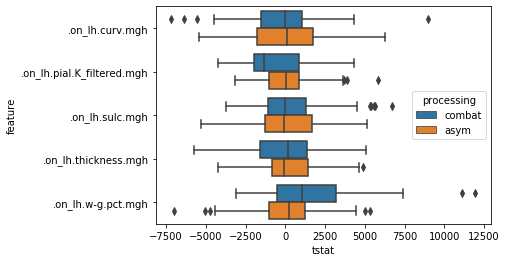

In [145]:
# bring stats in right format for plotting
df = pd.melt(stats, id_vars='processing', var_name='feature', value_name='tstat') # value_vars=keys, value_name='key')
sns.boxplot(data=df, y='feature', x='tstat', hue='processing')

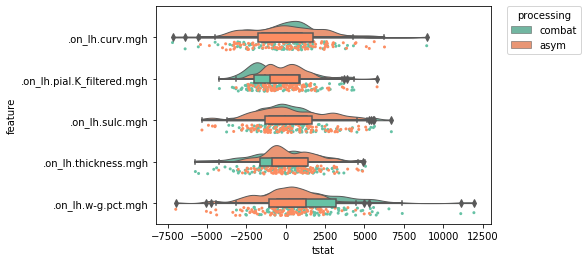

In [162]:
import ptitprince as pt

ax = pt.RainCloud(y = 'tstat', x = 'feature', hue='processing',
                  data = df, 
                  width_viol = .8,
                  width_box = .2,
                  figsize = (12, 8), orient = 'h',
                  move = .2,
                  offset=0)